In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import sklearn as sk
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
import pygmt
from obspy.core import UTCDateTime

In [2]:
# Read in features, look at names & datatypes
df_original = pd.read_csv('p_features.csv', dtype={'location_code': str})
print(len(df_original))
print(df_original.dtypes)

72952
arrival_identifier                int64
avg_noise_1.00                  float64
avg_noise_10.00                 float64
avg_noise_11.00                 float64
avg_noise_12.00                 float64
avg_noise_13.00                 float64
avg_noise_14.00                 float64
avg_noise_15.00                 float64
avg_noise_16.00                 float64
avg_noise_17.00                 float64
avg_noise_18.00                 float64
avg_noise_2.00                  float64
avg_noise_3.00                  float64
avg_noise_4.00                  float64
avg_noise_5.00                  float64
avg_noise_6.00                  float64
avg_noise_7.00                  float64
avg_noise_8.00                  float64
avg_noise_9.00                  float64
avg_signal_1.00                 float64
avg_signal_10.00                float64
avg_signal_11.00                float64
avg_signal_12.00                float64
avg_signal_13.00                float64
avg_signal_14.00                fl

In [3]:
# This catalog of events seems to be missing 2 events 60055267, 60071327
# ngb_event_df = pd.read_csv("NGB_events_201309_201407.csv")
# ngb_event_df

# df_ngb_old = df_original[np.isin(df_original.event_identifier, ngb_event_df.evid)]

In [4]:
# Get metadata for 1 and 3c stations
eq_meta_onec = pd.read_csv("currentEarthquakeArrivalInformation1CWithGains.csv")
eq_meta_threec = pd.read_csv("currentEarthquakeArrivalInformation3CWithGains.csv")
eq_meta_all = pd.concat([eq_meta_onec, eq_meta_threec])

# Reduce to just location information
all_eq_locs = eq_meta_all.drop_duplicates("evid")[["evid", "event_lat", "event_lon", "origin_time"]]
all_eq_locs.columns = ["event_identifier", "event_lat", "event_lon", "origin_time"]

# Reduce to events in the dataset 
eq_locs_df = all_eq_locs[np.isin(all_eq_locs.event_identifier, df_original.event_identifier.unique())]
# Make date column for filtering
eq_locs_df.loc[:, "date"] = eq_locs_df.origin_time.apply(lambda x: int(UTCDateTime(x).strftime("%y%m%d")))

/tmp/ipykernel_6204/2636885443.py:3: DtypeWarning: Columns (3) have mixed types. Specify dtype option on import or set low_memory=False.
  eq_meta_threec = pd.read_csv("currentEarthquakeArrivalInformation3CWithGains.csv")
/tmp/ipykernel_6204/2636885443.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  eq_locs_df.loc[:, "date"] = eq_locs_df.origin_time.apply(lambda x: int(UTCDateTime(x).strftime("%y%m%d")))


In [5]:
# Set filter bounds
lat_min = 44.680
lat_max = 44.870
lon_max = 110.850
lon_min = 110.640
date_min = 130901  # YYMMDD
date_max = 140630  # YYMMDD
bounds = {"lat_min": lat_min,
          "lat_max": lat_max,
          "lon_max": lon_max,
          "lon_min": lon_min,
          "date_min": date_min,
          "date_max": date_max}

# Get ngb event ids
ngb_event_locs = eq_locs_df.loc[
        (eq_locs_df["date"] >= bounds["date_min"]) & (eq_locs_df["date"] <= bounds["date_max"]) & (eq_locs_df["event_lat"] >= bounds["lat_min"])
        & (eq_locs_df["event_lat"] <= bounds["lat_max"]) & (-1 * eq_locs_df["event_lon"] >= bounds["lon_min"]) & (
                    -1 * eq_locs_df["event_lon"] <= bounds["lon_max"])]

In [6]:
df_ngb_removed = df_original[~np.isin(df_original.event_identifier, ngb_event_locs.event_identifier)]
df_ngb = df_original[np.isin(df_original.event_identifier, ngb_event_locs.event_identifier)]
np.where(np.isin(df_ngb_removed.event_identifier, df_ngb.event_identifier))

(array([], dtype=int64),)

In [7]:
# Read in park and caldera boundaries
utahnet_path = "../maps/utahnet"
ys_border = pd.read_csv(f"{utahnet_path}/yell.border.g", delimiter=" ", names=["Longitude", "Latitude"], dtype=np.float64)
caldera = pd.read_csv(f"{utahnet_path}/caldera.ys", sep="\s+", names=["Latitude", "Longitude"], dtype=np.float64)

caldera = caldera.drop(caldera[caldera["Longitude"]==0].index)
caldera = caldera[["Longitude", "Latitude"]]
caldera["Longitude"] = caldera["Longitude"]*-1

In [8]:
# Lat/lon bounding box I could use to scale the source locations
bb_lat_min = ys_border.Latitude.min() - 0.2
bb_lat_max = ys_border.Latitude.max()
bb_lon_min = ys_border.Longitude.min() - 0.15
bb_lon_max = ys_border.Longitude.max()
ys_bb = [[bb_lon_max, bb_lat_max], [bb_lon_max, bb_lat_min], [bb_lon_min, bb_lat_min], [bb_lon_min, bb_lat_max], [bb_lon_max, bb_lat_max]]

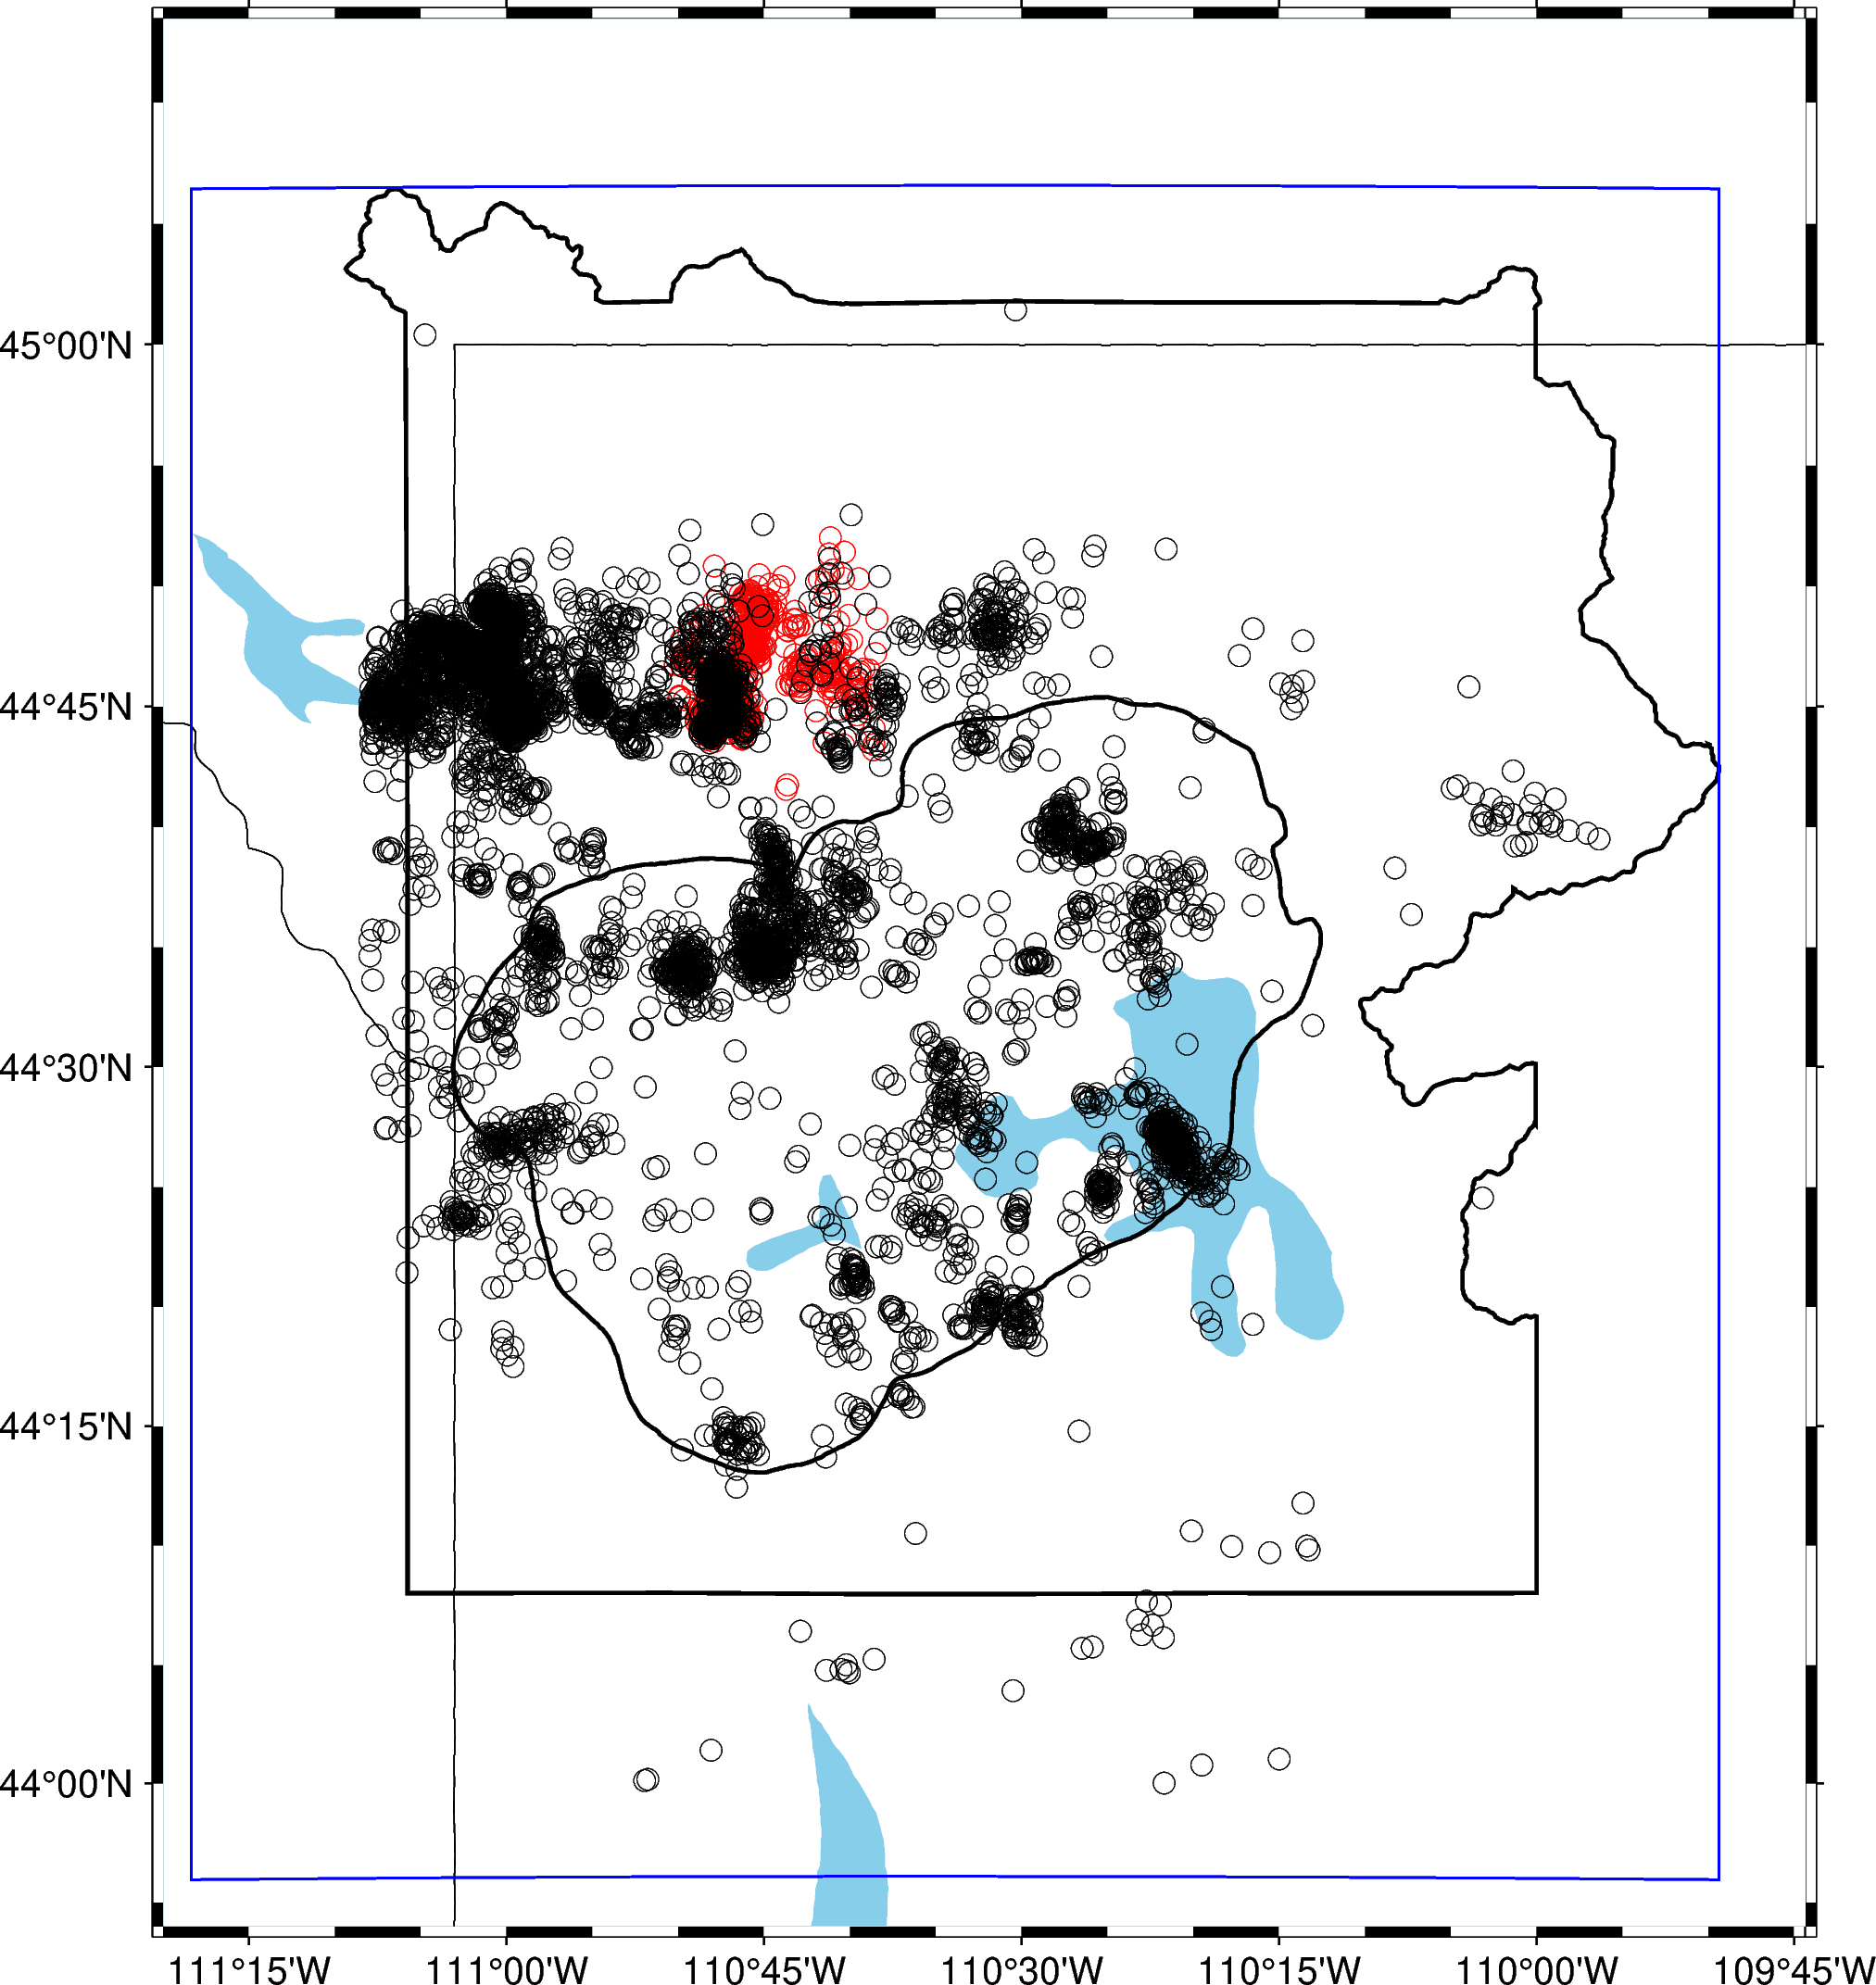

In [9]:
#Draw event map 
region = [
    eq_locs_df.event_lon.min() - 0.2,
    eq_locs_df.event_lon.max() + 0.2,
    eq_locs_df.event_lat.min() - 0.1,
    eq_locs_df.event_lat.max() + 0.2,
]

unique_locations = df_ngb_removed[["source_longitude", "source_latitude"]].drop_duplicates()
unique_ngb_locations = df_ngb[["source_longitude", "source_latitude"]].drop_duplicates()

fig = pygmt.Figure()
fig.basemap(region=region, projection="M15c", frame=True)
fig.coast(land="white", borders=2, water="skyblue")
fig.plot(data=ys_border, pen="1.0p,black")
fig.plot(data=caldera, pen='1.0p,black')
fig.plot(x=unique_ngb_locations.source_longitude, y=unique_ngb_locations.source_latitude, style="c0.2c", pen="0.2p,red")
fig.plot(x=unique_locations.source_longitude, y=unique_locations.source_latitude, style="c0.2c", pen="0.2p,black")
fig.plot(ys_bb, pen="0.6p,blue")
fig.show()

In [10]:
# Keep stations with more than 350 observations
stat_counts = df_original.value_counts("station").to_frame().reset_index()
stat_counts.columns = ["Station", "Count"]
df_org_filtcounts = df_ngb_removed[np.isin(df_ngb_removed.station, stat_counts[stat_counts.Count >= 350])]

## Feature selection?

In [11]:
# Make train and test datasets

test_size = 0.2
station = "YMC"

station_df = df_org_filtcounts[df_org_filtcounts.station == station]

evids = np.unique(station_df.event_identifier)
train_evids, test_evids = train_test_split(evids, test_size = test_size, random_state = 843823)

train_inds = np.isin(station_df.event_identifier, train_evids)
train_df = station_df[train_inds]
test_df = station_df[~train_inds]

assert len(train_df.event_identifier.unique()) == len(train_evids)
assert len(test_df.event_identifier.unique()) == len(test_evids)
assert len(test_df) + len(train_df) == len(station_df)

In [12]:
# Computes the feature matrix from a dataframe
def compute_feature_df(df, scaler = True):
    # Loosely speaking empirical magnitudes look like:
    # M = log10(A) + Q(Delta) 
    # where A is the amplitude and Q a distance dependent correction term.
    # Additionally, the difference between log10 and log amounts to a scalar
    # that a machine can learn.
    # Basically, I'm interested in features that:
    #   (1) Measure size in, potentially, different amplitudes.
    # different `passbands' deviates from the noise, 
    n_rows = len(df)
    n_columns = 48
    X = np.zeros([n_rows, n_columns])
    # Get a proxy on size
    
    # These are effectively amplitude ratios.  Note,
    # log(a/b) = log(a) - log(b)
    X[:,0]  = np.log(df['avg_signal_1.00']) - np.log(df['avg_noise_1.00'])
    X[:,1]  = np.log(df['avg_signal_2.00']) - np.log(df['avg_noise_2.00'])
    X[:,2]  = np.log(df['avg_signal_3.00']) - np.log(df['avg_noise_3.00'])
    X[:,3]  = np.log(df['avg_signal_4.00']) - np.log(df['avg_noise_4.00'])
    X[:,4]  = np.log(df['avg_signal_5.00']) - np.log(df['avg_noise_5.00'])
    X[:,5]  = np.log(df['avg_signal_6.00']) - np.log(df['avg_noise_6.00'])
    X[:,6]  = np.log(df['avg_signal_7.00']) - np.log(df['avg_noise_7.00'])
    X[:,7]  = np.log(df['avg_signal_8.00']) - np.log(df['avg_noise_8.00'])
    X[:,8]  = np.log(df['avg_signal_9.00']) - np.log(df['avg_noise_9.00'])
    X[:,9]  = np.log(df['avg_signal_10.00']) - np.log(df['avg_noise_10.00'])
    X[:,10] = np.log(df['avg_signal_11.00']) - np.log(df['avg_noise_11.00'])
    X[:,11] = np.log(df['avg_signal_12.00']) - np.log(df['avg_noise_12.00'])
    X[:,12] = np.log(df['avg_signal_13.00']) - np.log(df['avg_noise_13.00'])
    X[:,13] = np.log(df['avg_signal_14.00']) - np.log(df['avg_noise_14.00'])
    X[:,14] = np.log(df['avg_signal_15.00']) - np.log(df['avg_noise_15.00'])
    X[:,15] = np.log(df['avg_signal_16.00']) - np.log(df['avg_noise_16.00'])
    X[:,16] = np.log(df['avg_signal_17.00']) - np.log(df['avg_noise_17.00'])
    X[:,17] = np.log(df['avg_signal_18.00']) - np.log(df['avg_noise_18.00'])
    # Look at amplitudes
    X[:,18] = np.log(df['avg_signal_1.00']) 
    X[:,19] = np.log(df['avg_signal_2.00']) 
    X[:,20] = np.log(df['avg_signal_3.00']) 
    X[:,21] = np.log(df['avg_signal_4.00']) 
    X[:,22] = np.log(df['avg_signal_5.00'])
    X[:,23] = np.log(df['avg_signal_6.00'])
    X[:,24] = np.log(df['avg_signal_7.00'])
    X[:,25] = np.log(df['avg_signal_8.00'])
    X[:,26] = np.log(df['avg_signal_9.00'])
    X[:,27] = np.log(df['avg_signal_10.00'])
    X[:,28] = np.log(df['avg_signal_11.00'])
    X[:,29] = np.log(df['avg_signal_12.00'])
    X[:,30] = np.log(df['avg_signal_13.00'])
    X[:,31] = np.log(df['avg_signal_14.00'])
    X[:,32] = np.log(df['avg_signal_15.00'])
    X[:,33] = np.log(df['avg_signal_16.00'])
    X[:,34] = np.log(df['avg_signal_17.00'])
    X[:,35] = np.log(df['avg_signal_18.00'])
    # Frequency and max amplitude
    X[:,36] = np.log(df['signal_dominant_frequency'])
    X[:,37] = np.log(df['signal_dominant_amplitude'])
    # Time-based featuers: Look at max amplitudes of noise/signal
    X[:,38] = np.log(df['noise_maximum_value']  - df['noise_minimum_value'])
    X[:,39] = np.log(df['signal_maximum_value'] - df['signal_minimum_value'])
    X[:,40] = np.log(df['signal_variance'])
    X[:,41] = np.log(df['noise_variance'])
    # Source/recv distance (take log to flatten this)
    X[:,42] = np.log(df['source_receiver_distance_km'])
    X[:,43] = df['source_depth_km']
    # Single stations can learn location
    X[:,44] = df['source_latitude']
    X[:,45] = df['source_longitude']
    X[:,46] = np.sin(df['source_receiver_back_azimuth'])
    X[:,47] = df['source_receiver_back_azimuth']

    
    # Standardize features
    if (scaler):
        scaler = StandardScaler()
        scaler = scaler.fit(X)
        X = scaler.transform(X)
        return X, scaler
    
    return X
    
#X, scaler = compute_feature_matrix(df)

In [13]:
train_feat_matrix_scaled, scaler = compute_feature_df(train_df)
train_feat_matrix_unscaled = compute_feature_df(train_df, scaler=False)

train_y = train_df.magnitude.values

In [14]:
train_feat_matrix_scaled[0], train_feat_matrix_unscaled[0]

(array([ 0.22721317,  0.17664873,  0.31867821,  0.02191162, -0.40201179,
        -1.4495507 , -1.67311522, -1.60859162, -1.53437208, -1.49862219,
        -1.49518523, -1.51129406, -1.53302452, -1.55132457, -1.56595701,
        -1.57850167, -1.5887797 , -1.59596011,  0.68177318,  0.43526613,
         0.64029857,  0.49681014,  0.26419434,  0.1300943 ,  0.04738385,
        -0.05395504, -0.15880256, -0.23730206, -0.27824207, -0.28865401,
        -0.28703853, -0.28336628, -0.28016989, -0.27879143, -0.27881723,
        -0.27968381, -1.26657149,  0.2694669 ,  1.19178315,  0.16571885,
         0.17613762,  1.14024443,  1.43888609,  1.93886713, -2.92583736,
        -0.65175036,  0.44945198, -0.05560294]),
 array([ 2.57696477e+00,  2.96839857e+00,  3.51224391e+00,  3.81648054e+00,
         3.89338847e+00,  3.12942011e+00,  2.79427490e+00,  2.59943407e+00,
         2.42576183e+00,  2.27622803e+00,  2.14480871e+00,  2.02604556e+00,
         1.92530370e+00,  1.84808325e+00,  1.78879874e+00,  1.7408

In [15]:
train_y

array([2.52, 3.16, 2.47, ..., 2.56, 1.62, 0.87])

In [16]:
train_feat_df = pd.DataFrame(train_feat_matrix_scaled, columns=["amp_ratio_01.0", "amp_ratio_02.0", "amp_ratio_03.0", "amp_ratio_04.0", 
                                 "amp_ratio_05.0", "amp_ratio_06.0", "amp_ratio_07.0", "amp_ratio_08.0",
                                 "amp_ratio_09.0", "amp_ratio_10.0", "amp_ratio_11.0", "amp_ratio_12.0", 
                                 "amp_ratio_13.0", "amp_ratio_14.0", "amp_ratio_15.0", "amp_ratio_16.0", 
                                 "amp_ratio_17.0", "amp_ratio_18.0", 
                                 "amp_01.0", "amp_02.0", "amp_03.0", "amp_04.0", 
                                 "amp_05.0", "amp_06.0", "amp_07.0", "amp_08.0",
                                 "amp_09.0", "amp_10.0", "amp_11.0", "amp_12.0", 
                                 "amp_13.0", "amp_14.0", "amp_15.0", "amp_16.0", 
                                 "amp_17.0", "amp_18.0",
                                 "signal_dominant_frequency", "signal_dominant_amplitude", 
                                 "noise_max_amplitude", "signal_max_amplitude", "signal_variance", "noise_variance",
                                 "source_receiver_distance_logkm", "source_depth_km","source_latitude", "source_longitude", 
                                 "sin_receiver_back_azimuth", "receiver_back_azimuth"])

In [17]:
train_feat_df_unscaled = pd.DataFrame(train_feat_matrix_unscaled, columns=["amp_ratio_01.0", "amp_ratio_02.0", "amp_ratio_03.0", "amp_ratio_04.0", 
                                 "amp_ratio_05.0", "amp_ratio_06.0", "amp_ratio_07.0", "amp_ratio_08.0",
                                 "amp_ratio_09.0", "amp_ratio_10.0", "amp_ratio_11.0", "amp_ratio_12.0", 
                                 "amp_ratio_13.0", "amp_ratio_14.0", "amp_ratio_15.0", "amp_ratio_16.0", 
                                 "amp_ratio_17.0", "amp_ratio_18.0", 
                                 "amp_01.0", "amp_02.0", "amp_03.0", "amp_04.0", 
                                 "amp_05.0", "amp_06.0", "amp_07.0", "amp_08.0",
                                 "amp_09.0", "amp_10.0", "amp_11.0", "amp_12.0", 
                                 "amp_13.0", "amp_14.0", "amp_15.0", "amp_16.0", 
                                 "amp_17.0", "amp_18.0",
                                 "signal_dominant_frequency", "signal_dominant_amplitude", 
                                 "noise_max_amplitude", "signal_max_amplitude", "signal_variance", "noise_variance",
                                 "source_receiver_distance_logkm", "source_depth_km","source_latitude", "source_longitude", 
                                 "sin_receiver_back_azimuth", "receiver_back_azimuth"])

In [18]:
feat_target_df = train_feat_df.copy()
feat_target_df.loc[:, "magnitude"] = train_y
corr = feat_target_df.corr()
corr.style.background_gradient(cmap="coolwarm")

,amp_ratio_01.0,amp_ratio_02.0,amp_ratio_03.0,amp_ratio_04.0,amp_ratio_05.0,amp_ratio_06.0,amp_ratio_07.0,amp_ratio_08.0,amp_ratio_09.0,amp_ratio_10.0,amp_ratio_11.0,amp_ratio_12.0,amp_ratio_13.0,amp_ratio_14.0,amp_ratio_15.0,amp_ratio_16.0,amp_ratio_17.0,amp_ratio_18.0,amp_01.0,amp_02.0,amp_03.0,amp_04.0,amp_05.0,amp_06.0,amp_07.0,amp_08.0,amp_09.0,amp_10.0,amp_11.0,amp_12.0,amp_13.0,amp_14.0,amp_15.0,amp_16.0,amp_17.0,amp_18.0,signal_dominant_frequency,signal_dominant_amplitude,noise_max_amplitude,signal_max_amplitude,signal_variance,noise_variance,source_receiver_distance_logkm,source_depth_km,source_latitude,source_longitude,sin_receiver_back_azimuth,receiver_back_azimuth,magnitude
amp_ratio_01.0,1.000000,0.585480,0.504355,0.454838,0.439051,0.400307,0.355973,0.319573,0.289162,0.266185,0.250792,0.240601,0.233636,0.228833,0.225576,0.223495,0.222306,0.221781,0.306092,0.247696,0.240150,0.230897,0.236897,0.239227,0.239519,0.238472,0.235363,0.231804,0.228940,0.226809,0.225137,0.223745,0.222565,0.221551,0.220685,0.219952,0.065222,0.271267,0.031512,0.269535,0.258290,0.032791,-0.152621,-0.031997,0.060848,-0.086618,-0.007247,0.067509,0.130479
amp_ratio_02.0,0.585480,1.000000,0.793747,0.691063,0.613902,0.525125,0.444726,0.373903,0.319249,0.280134,0.254024,0.237149,0.226197,0.218863,0.213910,0.210567,0.208353,0.206961,0.164539,0.264457,0.217702,0.191913,0.186528,0.183745,0.180574,0.177071,0.173304,0.169147,0.165349,0.162348,0.160000,0.158137,0.156612,0.155307,0.154181,0.153201,-0.010058,0.234909,-0.069703,0.229221,0.211013,-0.067972,-0.117205,-0.053664,0.133146,0.005837,0.000656,0.019742,0.125640
amp_ratio_03.0,0.504355,0.793747,1.000000,0.875131,0.774416,0.683223,0.596010,0.514607,0.449575,0.403114,0.372554,0.352660,0.339355,0.330120,0.323535,0.318696,0.315090,0.312388,0.175777,0.260161,0.317983,0.285474,0.269050,0.265076,0.261740,0.257972,0.253384,0.247985,0.242953,0.238895,0.235646,0.233005,0.230787,0.228853,0.227142,0.225614,0.021918,0.323387,-0.110778,0.317957,0.290721,-0.108291,-0.191691,0.045290,0.189424,-0.121126,0.000362,0.047602,0.079373
amp_ratio_04.0,0.454838,0.691063,0.875131,1.000000,0.909603,0.786984,0.686268,0.597640,0.524292,0.470188,0.433832,0.409954,0.394002,0.382966,0.375154,0.369485,0.365305,0.362176,0.178644,0.261513,0.315880,0.336551,0.316371,0.297709,0.286269,0.278515,0.271309,0.263621,0.256463,0.250609,0.245956,0.242263,0.239280,0.236795,0.234683,0.232861,-0.025187,0.351138,-0.158294,0.339938,0.313631,-0.154114,-0.166143,0.033649,0.197463,-0.111066,0.009133,0.008495,0.090577
amp_ratio_05.0,0.439051,0.613902,0.774416,0.909603,1.000000,0.948732,0.866098,0.786867,0.720695,0.670644,0.635847,0.612484,0.596758,0.585864,0.578170,0.572627,0.568573,0.565559,0.330426,0.417927,0.470523,0.494616,0.504597,0.496467,0.485778,0.476922,0.468088,0.459161,0.451425,0.445419,0.440851,0.437301,0.434435,0.432018,0.429919,0.428064,0.093950,0.535667,-0.085385,0.526921,0.501241,-0.078955,-0.348020,0.158208,0.342983,-0.278196,0.014657,0.150110,0.088423
amp_ratio_06.0,0.400307,0.525125,0.683223,0.786984,0.948732,1.000000,0.968182,0.908958,0.853838,0.810979,0.780421,0.759478,0.745223,0.735302,0.728266,0.723170,0.719410,0.716586,0.440952,0.528396,0.585320,0.601890,0.622357,0.629449,0.626281,0.619463,0.610548,0.601313,0.593537,0.587677,0.583354,0.580069,0.577438,0.575213,0.573262,0.571515,0.192108,0.656644,-0.016158,0.652402,0.628994,-0.007563,-0.482943,0.243027,0.436448,-0.415719,0.021672,0.245424,0.083226
amp_ratio_07.0,0.355973,0.444726,0.596010,0.686268,0.866098,0.968182,1.000000,0.978836,0.940876,0.906637,0.880657,0.862255,0.849534,0.840643,0.834351,0.829810,0.826471,0.823970,0.526771,0.613958,0.671056,0.684033,0.703106,0.714513,0.717783,0.715474,0.708848,0.700804,0.693676,0.688183,0.684095,0.680991,0.678520,0.676445,0.674632,0.673012,0.243849,0.735135,0.050581,0.734507,0.715307,0.060945,-0.571617,0.269677,0.502533,-0.495319,0.028908,0.297896,0.100398
amp_ratio_08.0,0.319573,0.373903,0.514607,0.597640,0.786867,0.908958,0.978836,1.00000

In [19]:
from sklearn.feature_selection import mutual_info_regression, SequentialFeatureSelector, RFE

In [20]:
mutual_reg = mutual_info_regression(train_feat_matrix_scaled, train_y, random_state=843824)
mutual_reg

array([0.02654221, 0.00960748, 0.07351565, 0.04228979, 0.02777684,
       0.0534925 , 0.05338796, 0.05991322, 0.04787984, 0.0576756 ,
       0.06609478, 0.07728212, 0.07477453, 0.07598824, 0.07892132,
       0.07978598, 0.08803166, 0.09835398, 0.25836974, 0.28413234,
       0.2806682 , 0.25985709, 0.26673007, 0.26002636, 0.25680966,
       0.25154367, 0.24239571, 0.23807709, 0.2477657 , 0.2380459 ,
       0.2344807 , 0.23655108, 0.24774754, 0.25698108, 0.26994155,
       0.27320147, 0.06535015, 0.29346079, 0.21468571, 0.31185776,
       0.32394478, 0.21416116, 0.10917075, 0.03831104, 0.04801993,
       0.11846385, 0.01216554, 0.06113027])

In [21]:
train_feat_df.columns[np.argsort(mutual_reg, axis=0)]

Index(['amp_ratio_02.0', 'sin_receiver_back_azimuth', 'amp_ratio_01.0',
       'amp_ratio_05.0', 'source_depth_km', 'amp_ratio_04.0', 'amp_ratio_09.0',
       'source_latitude', 'amp_ratio_07.0', 'amp_ratio_06.0', 'amp_ratio_10.0',
       'amp_ratio_08.0', 'receiver_back_azimuth', 'signal_dominant_frequency',
       'amp_ratio_11.0', 'amp_ratio_03.0', 'amp_ratio_13.0', 'amp_ratio_14.0',
       'amp_ratio_12.0', 'amp_ratio_15.0', 'amp_ratio_16.0', 'amp_ratio_17.0',
       'amp_ratio_18.0', 'source_receiver_distance_logkm', 'source_longitude',
       'noise_variance', 'noise_max_amplitude', 'amp_13.0', 'amp_14.0',
       'amp_12.0', 'amp_10.0', 'amp_09.0', 'amp_15.0', 'amp_11.0', 'amp_08.0',
       'amp_07.0', 'amp_16.0', 'amp_01.0', 'amp_04.0', 'amp_06.0', 'amp_05.0',
       'amp_17.0', 'amp_18.0', 'amp_03.0', 'amp_02.0',
       'signal_dominant_amplitude', 'signal_max_amplitude', 'signal_variance'],
      dtype='object')

In [19]:
# Make cross validation splits across evids

from sklearn.model_selection import KFold
evids = train_df.event_identifier.unique()
kf = KFold(n_splits=5, shuffle=True, random_state=843824)
folds = []
for train_index, test_index in kf.split(evids):
    # Get the evids corresponding to the split indicies
    fold_train_evids = evids[train_index]
    fold_test_evids = evids[test_index]
    # Get rows of training dataset that correspond to split evids
    fold_train_inds = np.where(np.isin(train_df.event_identifier, fold_train_evids))[0]
    fold_test_inds = np.where(np.isin(train_df.event_identifier, fold_test_evids))[0]
    
    folds.append((fold_train_inds, fold_test_inds))

In [20]:
from sklearn.svm import SVR
from sklearn.pipeline import Pipeline
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV, cross_validate
from sklearn.metrics import r2_score

## RFE

from RFECV, know that most of the gain comes from 5-10 features. Use RFE to find 8 "best" features

In [24]:
train_feat_df.columns[:-1]

Index(['amp_ratio_01.0', 'amp_ratio_02.0', 'amp_ratio_03.0', 'amp_ratio_04.0',
       'amp_ratio_05.0', 'amp_ratio_06.0', 'amp_ratio_07.0', 'amp_ratio_08.0',
       'amp_ratio_09.0', 'amp_ratio_10.0', 'amp_ratio_11.0', 'amp_ratio_12.0',
       'amp_ratio_13.0', 'amp_ratio_14.0', 'amp_ratio_15.0', 'amp_ratio_16.0',
       'amp_ratio_17.0', 'amp_ratio_18.0', 'amp_01.0', 'amp_02.0', 'amp_03.0',
       'amp_04.0', 'amp_05.0', 'amp_06.0', 'amp_07.0', 'amp_08.0', 'amp_09.0',
       'amp_10.0', 'amp_11.0', 'amp_12.0', 'amp_13.0', 'amp_14.0', 'amp_15.0',
       'amp_16.0', 'amp_17.0', 'amp_18.0', 'signal_dominant_frequency',
       'signal_dominant_amplitude', 'noise_max_amplitude',
       'signal_max_amplitude', 'signal_variance', 'noise_variance',
       'source_receiver_distance_logkm', 'source_depth_km', 'source_latitude',
       'source_longitude', 'sin_receiver_back_azimuth'],
      dtype='object')

In [25]:
# Find best features for whole training dataset
estimator = SVR(kernel="linear")
selector = RFE(estimator, n_features_to_select=8, step=1)
selector = selector.fit(train_feat_matrix_scaled[:, :-1], train_y)

train_feat_df.columns[:-1][selector.support_]

Index(['amp_09.0', 'amp_11.0', 'amp_14.0', 'amp_15.0', 'amp_16.0', 'amp_18.0',
       'signal_max_amplitude', 'signal_variance'],
      dtype='object')

In [26]:
# Sort features by importance - first 8 are in no particular order
train_feat_df.columns[:-1][np.argsort(selector.ranking_)]

Index(['amp_16.0', 'amp_15.0', 'amp_14.0', 'amp_11.0', 'signal_max_amplitude',
       'amp_18.0', 'amp_09.0', 'signal_variance', 'amp_17.0',
       'source_receiver_distance_logkm', 'amp_13.0', 'source_longitude',
       'amp_05.0', 'noise_variance', 'amp_08.0', 'amp_06.0', 'amp_ratio_16.0',
       'amp_ratio_18.0', 'amp_ratio_13.0', 'amp_ratio_15.0', 'amp_02.0',
       'amp_03.0', 'amp_10.0', 'source_latitude', 'amp_ratio_10.0',
       'amp_ratio_07.0', 'noise_max_amplitude', 'amp_07.0', 'amp_ratio_06.0',
       'amp_ratio_05.0', 'amp_12.0', 'source_depth_km', 'amp_ratio_09.0',
       'amp_ratio_12.0', 'amp_01.0', 'amp_ratio_04.0', 'amp_ratio_03.0',
       'amp_ratio_01.0', 'amp_04.0', 'amp_ratio_17.0', 'amp_ratio_08.0',
       'amp_ratio_11.0', 'amp_ratio_02.0', 'signal_dominant_amplitude',
       'sin_receiver_back_azimuth', 'signal_dominant_frequency',
       'amp_ratio_14.0'],
      dtype='object')

In [27]:
# Training performace with these 8 features in the linear model 
r2_score(selector.predict(train_feat_matrix_scaled[:, :-1]), train_y)

-0.323181341122601

In [28]:
# CV performace with these 8 features in non-linear model
svr = SVR(C=1.0, epsilon=0.2)
pipeline = Pipeline(steps=[("scaler", StandardScaler()), ('svr', svr)])
cross_validate(pipeline, train_feat_matrix_unscaled[:, :-1][:, selector.support_], train_y, cv=folds, scoring="r2")

{'fit_time': array([0.23722863, 0.23874974, 0.23643732, 0.23750639, 0.24052405]),
 'score_time': array([0.0497458 , 0.0504055 , 0.05011773, 0.05073047, 0.05120492]),
 'test_score': array([0.46898832, 0.5176531 , 0.46205092, 0.5141646 , 0.43804776])}

In [29]:
# Get best RFE features for various folds and evaluate 
for fold in folds:
    # Pipeline for choosing features for fold
    estimator = SVR(kernel="linear")
    selector = RFE(estimator, n_features_to_select=8, step=1)
    pipeline = Pipeline(steps=[("scaler", StandardScaler()), ('selector', selector)])
    
    # Fold data - exclude receiver_back_azimuth since linear model
    cv_train_X = train_feat_matrix_unscaled[fold[0], :-1]
    cv_train_y = train_y[fold[0]]
    cv_test_X = train_feat_matrix_unscaled[fold[1], :-1]
    cv_test_y = train_y[fold[1]]
    
    # Fit selector to fold training data
    s = pipeline.fit(cv_train_X, cv_train_y)
    # Make predictions on the fold test data
    preds = s.predict(cv_test_X)
    # Get the features for this model
    support = s.named_steps.selector.support_
    # Print the features
    print(train_feat_df.columns[:-1][support])
    # Print the test R^2 score
    print(r2_score(cv_test_y, preds))
    
    # Use this features in a non-linear model. Cross validate over all the folds
    svr = SVR(C=1.0, epsilon=0.2)
    nl_pipeline = Pipeline(steps=[("scaler", StandardScaler()), ('svr', svr)])
    print(cross_validate(nl_pipeline, train_feat_matrix_unscaled[:, :-1][:, support],
                         train_y, cv=folds, scoring="r2")["test_score"])

Index(['amp_09.0', 'amp_11.0', 'amp_14.0', 'amp_15.0', 'amp_16.0', 'amp_18.0',
       'signal_max_amplitude', 'signal_variance'],
      dtype='object')
0.4321262907726767
[0.46898832 0.5176531  0.46205092 0.5141646  0.43804776]
Index(['amp_08.0', 'amp_14.0', 'amp_15.0', 'amp_16.0', 'amp_17.0', 'amp_18.0',
       'signal_max_amplitude', 'signal_variance'],
      dtype='object')
0.4784086199203692
[0.47283541 0.52591129 0.46544939 0.52211102 0.44035567]
Index(['amp_09.0', 'amp_14.0', 'amp_15.0', 'amp_16.0', 'amp_17.0', 'amp_18.0',
       'signal_max_amplitude', 'signal_variance'],
      dtype='object')
0.4165068498318162
[0.47070611 0.51949141 0.46204278 0.5164377  0.44063432]
Index(['amp_08.0', 'amp_14.0', 'amp_15.0', 'amp_16.0', 'amp_17.0', 'amp_18.0',
       'signal_max_amplitude', 'signal_variance'],
      dtype='object')
0.4541056297388293
[0.47283541 0.52591129 0.46544939 0.52211102 0.44035567]
Index(['amp_09.0', 'amp_14.0', 'amp_15.0', 'amp_16.0', 'amp_18.0',
       'signal_max_am

## Sequential Feature Selection. 
Forward selection until change in score is less than 1e-4 or reach half of the features. Slightly better CV performace with 13 features than 46 for non-linear SVR. Pretty comparable performace between the 13 and 46 features in linear SVR. 

In [30]:
svr = SVR(C=1.0, epsilon=0.2)
pipeline = Pipeline(steps=[("scaler", StandardScaler()), ('svr', svr)])
sfs = SequentialFeatureSelector(pipeline, n_features_to_select="auto", tol=1e-3, scoring="r2", 
                                cv=folds, n_jobs=3).fit(train_feat_matrix_unscaled, train_y)

sfs.get_feature_names_out(train_feat_df.columns)

array(['amp_ratio_03.0', 'amp_ratio_18.0', 'amp_01.0', 'amp_02.0',
       'amp_03.0', 'signal_variance', 'noise_variance',
       'source_receiver_distance_logkm', 'source_depth_km',
       'source_latitude', 'source_longitude'], dtype=object)

In [31]:
svr = SVR(C=1.0, epsilon=0.2)
pipeline = Pipeline(steps=[("scaler", StandardScaler()), ('svr', svr)])
cross_validate(pipeline, train_feat_matrix_unscaled[:, sfs.get_support()], train_y, cv=folds)

{'fit_time': array([0.17555237, 0.16290641, 0.1655395 , 0.16030073, 0.16717505]),
 'score_time': array([0.03209591, 0.03113508, 0.03243089, 0.03016305, 0.03180695]),
 'test_score': array([0.85562851, 0.84920859, 0.84203913, 0.84330363, 0.84769745])}

In [32]:
svr = SVR(C=1.0, epsilon=0.2)
pipeline = Pipeline(steps=[("scaler", StandardScaler()), ('svr', svr)])
sfs = SequentialFeatureSelector(pipeline, n_features_to_select="auto", tol=1e-4, scoring="r2", 
                                cv=folds, n_jobs=3).fit(train_feat_matrix_unscaled, train_y)

sfs.get_feature_names_out(train_feat_df.columns)

array(['amp_ratio_03.0', 'amp_ratio_18.0', 'amp_01.0', 'amp_02.0',
       'amp_03.0', 'amp_18.0', 'signal_variance', 'noise_variance',
       'source_receiver_distance_logkm', 'source_depth_km',
       'source_latitude', 'source_longitude'], dtype=object)

In [33]:
svr = SVR(C=1.0, epsilon=0.2)
pipeline = Pipeline(steps=[("scaler", StandardScaler()), ('svr', svr)])
cross_validate(pipeline, train_feat_matrix_unscaled[:, sfs.get_support()], train_y, cv=folds)

{'fit_time': array([0.17978621, 0.17060661, 0.17155313, 0.16557074, 0.16954589]),
 'score_time': array([0.03288174, 0.03212333, 0.03268981, 0.0310111 , 0.03272033]),
 'test_score': array([0.85568703, 0.85029165, 0.8407698 , 0.8453558 , 0.84944404])}

In [34]:
# Result when selecting 6 features
# array(['amp_01.0', 'amp_02.0', 'amp_12.0', 'signal_dominant_amplitude',
#        'source_receiver_distance_logkm', 'source_longitude'], dtype=object)
# 0.86665783, 0.86072235, 0.83637506, 0.87239198, 0.87021598

In [35]:
# Performance when using all features
svr = SVR(C=1.0, epsilon=0.2)
pipeline = Pipeline(steps=[("scaler", StandardScaler()), ('svr', svr)])
cross_validate(pipeline, train_feat_matrix_unscaled, train_y, cv=folds)

{'fit_time': array([0.18748593, 0.18907809, 0.18413258, 0.18476796, 0.19430041]),
 'score_time': array([0.04201555, 0.04261398, 0.04007602, 0.04227591, 0.04632735]),
 'test_score': array([0.83076708, 0.82635246, 0.81868481, 0.84129836, 0.82816539])}

# Go more in-depth into the effect of the more important features

In [21]:
all_selected_features = ['signal_dominant_amplitude', "signal_max_amplitude", "signal_variance", 
                         'source_longitude', "source_latitude", 'source_receiver_distance_logkm',
                         'source_depth_km', "receiver_back_azimuth", "amp_01.0", 
                         'amp_02.0','amp_ratio_03.0', "amp_03.0", "amp_18.0", "amp_ratio_01.0", 'noise_variance']

selected_features_lat_lon = ['signal_dominant_amplitude', "signal_max_amplitude", "signal_variance", 
                             'source_longitude', "source_latitude", 'source_depth_km', "amp_01.0", 
                             'amp_02.0','amp_ratio_03.0', "amp_03.0", "amp_18.0", "amp_ratio_01.0", 'noise_variance']

selected_features_sr = ['signal_dominant_amplitude', "signal_max_amplitude", "signal_variance", 
                        'source_receiver_distance_logkm','source_depth_km', "receiver_back_azimuth",
                        "amp_01.0", 'amp_02.0', 'amp_ratio_03.0', "amp_03.0", "amp_18.0", "amp_ratio_01.0", 'noise_variance']

In [22]:
def svr_cv(X, y, folds, C=1.0, epsilon=0.2):
    svr = SVR(C=C, epsilon=epsilon)
    pipeline = Pipeline(steps=[("scaler", StandardScaler()), ('svr', svr)])
    cv_scores = cross_validate(pipeline, X, y, scoring="r2", cv=folds)["test_score"]
    
    return cv_scores

In [23]:
def seq_feature_importance(selected_features, train_feat_df_unscaled):
    feat_selection = np.copy(selected_features)
    best_features = []
    r2_maxs = []
    r2_mins = []
    r2_means = []

    for it in range(len(selected_features)):
        print("iteration", it)
        print(best_features)

        it_r2_vals = []
    #     best_feat_ind = -1

        for feature_ind in range(len(feat_selection)):
            features = [feat_selection[feature_ind]]
            if len(best_features) == 0:
                train_X = train_feat_df_unscaled[features].values.reshape(-1, 1)
            else:
                features = np.concatenate([best_features, features])
                train_X = train_feat_df_unscaled[features].values

            cv_scores = svr_cv(train_X, train_y, folds)

            mean_cv = np.mean(cv_scores)
            print(features[-1], mean_cv)
    #         if mean_cv > max_r2:
    #             best_feat_ind = feature_ind
    #             max_r2 = mean_cv

            it_r2_vals.append(mean_cv)

        best_feat_ind = np.argmax(it_r2_vals)
        best_features.append(feat_selection[best_feat_ind])
        r2_means.append(np.mean(it_r2_vals))
        r2_mins.append(np.min(it_r2_vals))
        r2_maxs.append(np.max(it_r2_vals))

        feat_selection = np.delete(feat_selection, best_feat_ind)

    n_features = np.arange(1, len(selected_features)+1)
    plt.plot(n_features, r2_means, linestyle="--", color="k", label="mean")
    plt.plot(n_features, r2_mins, color="k", label="min")
    plt.fill_between(n_features, r2_maxs, r2_mins, color="gray")
    plt.plot(n_features, r2_maxs, marker="x", color="r", label="max")
    plt.xticks(n_features) #, labels=n_features[::-1]) #, labels=best_features, rotation=45);
    plt.grid()
    plt.xlabel("N Features") #("N Features to Choose From");
    plt.ylabel(r"Mean $R^2$ of 5-fold CV");
    plt.legend();
    
    return best_features

iteration 0
[]
signal_dominant_amplitude 0.24997137338871403
signal_max_amplitude 0.2593777656516799
signal_variance 0.26562158785557494
source_longitude 0.10486762258707134
source_latitude 0.020822233560016844
source_depth_km -0.017720963580981942
amp_01.0 0.32750022125205164
amp_02.0 0.32438774600586584
amp_ratio_03.0 0.008455050089468652
amp_03.0 0.29295838090205506
amp_18.0 0.2539431589577042
amp_ratio_01.0 0.014150903782690816
noise_variance 0.295200192008251
iteration 1
['amp_01.0']
signal_dominant_amplitude 0.4011712565275899
signal_max_amplitude 0.41935037539335884
signal_variance 0.40918179281034384
source_longitude 0.6334421337558213
source_latitude 0.501817317867391
source_depth_km 0.4004322208963636
amp_02.0 0.36521241275694905
amp_ratio_03.0 0.3438434233324489
amp_03.0 0.37446965178373415
amp_18.0 0.48563107228603497
amp_ratio_01.0 0.3596405381307875
noise_variance 0.38362061462773633
iteration 2
['amp_01.0', 'source_longitude']
signal_dominant_amplitude 0.6629630979367623

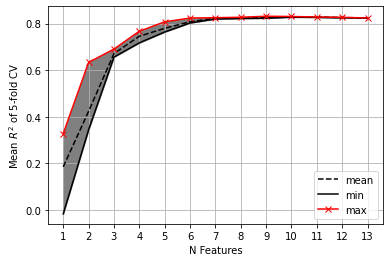

In [24]:
best_features_lat_lon = seq_feature_importance(selected_features_lat_lon, train_feat_df_unscaled)

In [25]:
# Best features when including lat, lon, and source_receiver_distance_logkm. Do not include receiver_back_azimith
# ['amp_01.0',
#  'source_longitude',
#  'amp_12.0',
#  'source_receiver_distance_logkm',
#  'amp_02.0',
#  'signal_dominant_amplitude',
#  'amp_ratio_01.0',
#  'source_latitude',
#  'amp_08.0',
#  'amp_18.0',
#  'source_depth_km',
#  'signal_max_amplitude',
#  'signal_variance']

In [26]:
best_features_lat_lon

['amp_01.0',
 'source_longitude',
 'source_latitude',
 'signal_variance',
 'noise_variance',
 'source_depth_km',
 'amp_18.0',
 'amp_ratio_03.0',
 'amp_03.0',
 'amp_02.0',
 'signal_dominant_amplitude',
 'signal_max_amplitude',
 'amp_ratio_01.0']

iteration 0
[]
signal_dominant_amplitude 0.24997137338871403
signal_max_amplitude 0.2593777656516799
signal_variance 0.26562158785557494
source_receiver_distance_logkm 0.10894966257384928
source_depth_km -0.017720963580981942
receiver_back_azimuth 0.031585338961818435
amp_01.0 0.32750022125205164
amp_02.0 0.32438774600586584
amp_ratio_03.0 0.008455050089468652
amp_03.0 0.29295838090205506
amp_18.0 0.2539431589577042
amp_ratio_01.0 0.014150903782690816
noise_variance 0.295200192008251
iteration 1
['amp_01.0']
signal_dominant_amplitude 0.4011712565275899
signal_max_amplitude 0.41935037539335884
signal_variance 0.40918179281034384
source_receiver_distance_logkm 0.6513951415414436
source_depth_km 0.4004322208963636
receiver_back_azimuth 0.4842908237207818
amp_02.0 0.36521241275694905
amp_ratio_03.0 0.3438434233324489
amp_03.0 0.37446965178373415
amp_18.0 0.48563107228603497
amp_ratio_01.0 0.3596405381307875
noise_variance 0.38362061462773633
iteration 2
['amp_01.0', 'source_receiver_distan

['amp_01.0',
 'source_receiver_distance_logkm',
 'signal_variance',
 'noise_variance',
 'receiver_back_azimuth',
 'source_depth_km',
 'amp_ratio_03.0',
 'amp_03.0',
 'amp_18.0',
 'amp_02.0',
 'signal_max_amplitude',
 'signal_dominant_amplitude',
 'amp_ratio_01.0']

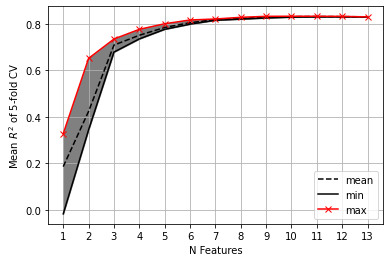

In [27]:
best_features_sr = seq_feature_importance(selected_features_sr, train_feat_df_unscaled)
best_features_sr

In [28]:
# All selected features with lat lon result
selected_feat_lat_lon_cv = svr_cv(train_feat_df_unscaled[selected_features_lat_lon], train_y, folds)
print(selected_feat_lat_lon_cv)
print(np.mean(selected_feat_lat_lon_cv))

[0.82263728 0.83407333 0.81481402 0.82459425 0.82564834]
0.8243534452634538


In [29]:
# Top 5 features with lat lon 
top_feat_lat_lon_cv = svr_cv(train_feat_df_unscaled[best_features_lat_lon[0:6]], train_y, folds)
print(top_feat_lat_lon_cv )
print(np.mean(top_feat_lat_lon_cv))

[0.82552729 0.83649659 0.81582146 0.81984569 0.82270697]
0.8240795997505981


In [30]:
# All selected features with sr distance and back azimuth
selected_feat_sr_cv = svr_cv(train_feat_df_unscaled[selected_features_sr], train_y, folds)
print(selected_feat_sr_cv)
print(np.mean(selected_feat_sr_cv))

[0.83317985 0.83672574 0.81327754 0.83323326 0.83257132]
0.8297975413986641


In [31]:
# Top 5 selected features with sr distance and back azimuth
top_feat_sr_cv = svr_cv(train_feat_df_unscaled[best_features_sr[0:8]], train_y, folds)
print(top_feat_sr_cv )
print(np.mean(top_feat_sr_cv))

[0.83079845 0.83756436 0.81844503 0.82435005 0.82846827]
0.82792523199738


In [32]:
selected_feat_df = train_feat_df.copy()[all_selected_features]
selected_feat_df.loc[:, "magnitude"] = train_y
corr = selected_feat_df.corr()
corr.style.background_gradient(cmap="coolwarm")

,signal_dominant_amplitude,signal_max_amplitude,signal_variance,source_longitude,source_latitude,source_receiver_distance_logkm,source_depth_km,receiver_back_azimuth,amp_01.0,amp_02.0,amp_ratio_03.0,amp_03.0,amp_18.0,amp_ratio_01.0,noise_variance,magnitude
signal_dominant_amplitude,1.000000,0.996829,0.994380,-0.634968,0.599908,-0.790609,0.311490,0.418156,0.862336,0.931975,0.323387,0.970768,0.962244,0.271267,0.630936,0.349249
signal_max_amplitude,0.996829,1.000000,0.996048,-0.651309,0.612090,-0.803939,0.312738,0.424951,0.862640,0.930654,0.317957,0.969906,0.972868,0.269535,0.632885,0.332811
signal_variance,0.994380,0.996048,1.000000,-0.633346,0.603263,-0.803982,0.298744,0.420874,0.884463,0.946194,0.290721,0.979177,0.977863,0.258290,0.663414,0.363915
source_longitude,-0.634968,-0.651309,-0.633346,1.000000,-0.448819,0.706822,-0.439816,-0.554433,-0.439651,-0.485914,-0.121126,-0.568767,-0.686518,-0.086618,-0.377368,0.208336
source_latitude,0.599908,0.612090,0.603263,-0.448819,1.000000,-0.661647,0.114509,0.261165,0.396860,0.525201,0.189424,0.563861,0.647019,0.060848,0.314428,-0.072614
source_receiver_distance_logkm,-0.790609,-0.803939,-0.803982,0.706822,-0.661647,1.000000,-0.225107,-0.408669,-0.641105,-0.702314,-0.191691,-0.756220,-0.843990,-0.152621,-0.532998,0.029026
source_depth_km,0.311490,0.312738,0.298744,-0.439816,0.114509,-0.225107,1.000000,0.359723,0.184531,0.208819,0.045290,0.268038,0.297715,-0.031997,0.143219,0.024245
receiver_back_azimuth,0.418156,0.424951,0.420874,-0.554433,0.261165,-0.408669,0.359723,1.000000,0.351252,0.375780,0.047602,0.386814,0.431457,0.067509,0.283790,0.003117
amp_01.0,0.862336,0.862640,0.884463,-0.439651,0.396860,-0.641105,0.184531,0.351252,1.000000,0.944447,0.175777,0.905315,0.855402,0.306092,0.742516,0.553534
amp_02.0,0.931975,0.930654,0.946194,-0.485914,0.525201,-0.702314,0.208819,0.375780,0.944447,1.000000,0.260161,0.968467,0.909916,0.247696,0.719528,0.513763


In [33]:
def add_feat_to_base(base_features, additional_features, all_features_cv=None, top_features_cv=None):

    cv_means = []

    for cf in additional_features:
        feat_list = base_features.copy()
        feat_list.append(cf)
        cv_vals = svr_cv(train_feat_df_unscaled[feat_list], train_y, folds)
        cv_means.append(np.mean(cv_vals))

    plt.scatter(range(len(additional_features)), cv_means, marker="x")
    plt.xticks(range(len(additional_features)), labels=additional_features, rotation=45);
    if all_features_cv is not None:
        plt.axhline(np.mean(all_features_cv))
    if top_features_cv is not None:
        plt.axhline(np.mean(top_features_cv), color="C1")
    plt.show()
    
    return cv_means

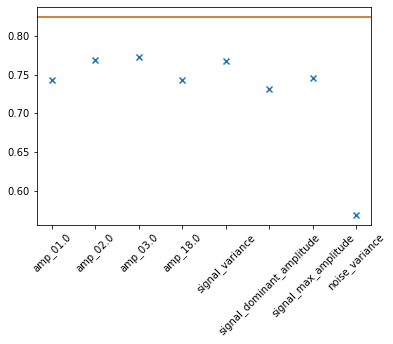

In [34]:
base_features = ['source_longitude', "source_latitude",'source_depth_km', 'amp_ratio_01.0']

correlated_features = ["amp_01.0", 'amp_02.0', "amp_03.0", "amp_18.0", "signal_variance", 
                       "signal_dominant_amplitude", "signal_max_amplitude", "noise_variance"]

cv_means = add_feat_to_base(base_features, correlated_features, all_features_cv=selected_feat_lat_lon_cv, 
                           top_features_cv=top_feat_lat_lon_cv)

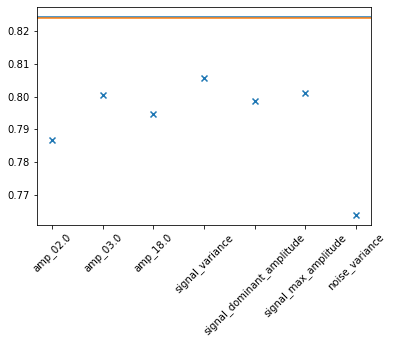

In [35]:
base_features = ['source_longitude', "source_latitude",'source_depth_km', 'amp_ratio_01.0', "amp_01.0"]

correlated_features = ['amp_02.0', "amp_03.0", "amp_18.0", "signal_variance", 
                       "signal_dominant_amplitude", "signal_max_amplitude", "noise_variance"]

cv_means_amp01  = add_feat_to_base(base_features, correlated_features, all_features_cv=selected_feat_lat_lon_cv, 
                           top_features_cv=top_feat_lat_lon_cv)

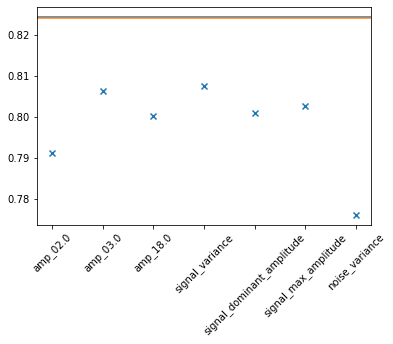

In [36]:
base_features = ['source_longitude', "source_latitude",'source_depth_km', 'amp_ratio_01.0', "amp_01.0", "amp_ratio_03.0"]

correlated_features = ['amp_02.0', "amp_03.0", "amp_18.0", "signal_variance", 
                       "signal_dominant_amplitude", "signal_max_amplitude", "noise_variance"]

cv_means_amp01_ampr03  = add_feat_to_base(base_features, correlated_features, all_features_cv=selected_feat_lat_lon_cv, 
                           top_features_cv=top_feat_lat_lon_cv)

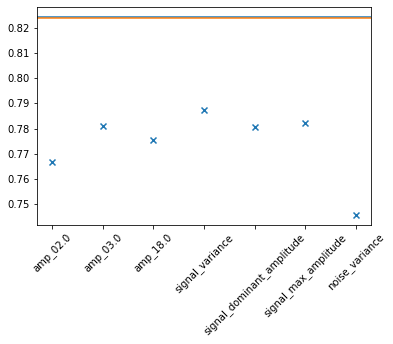

In [40]:
base_features = ['source_longitude', "source_latitude",'amp_ratio_01.0', "amp_01.0"]

correlated_features = ['amp_02.0', "amp_03.0", "amp_18.0", "signal_variance", 
                       "signal_dominant_amplitude", "signal_max_amplitude", "noise_variance"]

cv_means_nodepth = add_feat_to_base(base_features, correlated_features, all_features_cv=selected_feat_lat_lon_cv, 
                           top_features_cv=top_feat_lat_lon_cv)

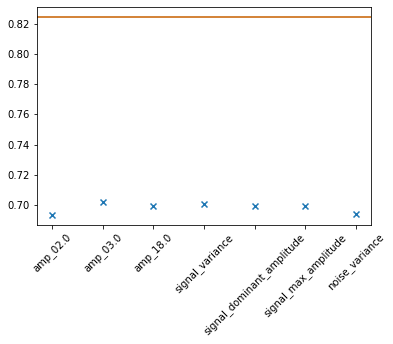

In [41]:
base_features = ['source_longitude','amp_ratio_01.0', "amp_01.0"]

correlated_features = ['amp_02.0', "amp_03.0","amp_18.0", "signal_variance", 
                       "signal_dominant_amplitude", "signal_max_amplitude", "noise_variance"]

cv_means_nodepth_nolat = add_feat_to_base(base_features, correlated_features, all_features_cv=selected_feat_lat_lon_cv, 
                           top_features_cv=top_feat_lat_lon_cv)

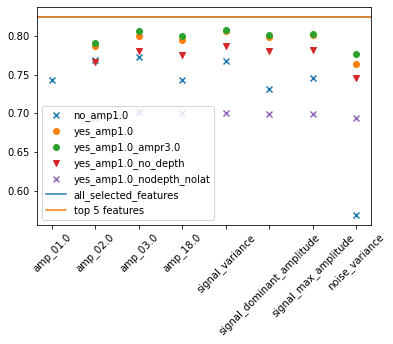

In [42]:
correlated_features = ["amp_01.0", 'amp_02.0',"amp_03.0", "amp_18.0", "signal_variance", 
                       "signal_dominant_amplitude", "signal_max_amplitude","noise_variance"]

plt.scatter( range(0,len(correlated_features)), cv_means, marker="x", label="no_amp1.0")
plt.scatter( range(1,len(correlated_features)), cv_means_amp01, marker="o", label="yes_amp1.0")
plt.scatter( range(1,len(correlated_features)), cv_means_amp01_ampr03, marker="o", label="yes_amp1.0_ampr3.0")
plt.scatter( range(1,len(correlated_features)), cv_means_nodepth, marker="v", label="yes_amp1.0_no_depth")
plt.scatter( range(1,len(correlated_features)), cv_means_nodepth_nolat, marker="x", label="yes_amp1.0_nodepth_nolat")

plt.xticks(range(len(correlated_features)), labels=correlated_features, rotation=45);
plt.axhline(np.mean(selected_feat_lat_lon_cv), label="all_selected_features")
plt.axhline(np.mean(top_feat_lat_lon_cv), color="C1", label="top 5 features")
plt.legend();

In [48]:
fewer_features_lat_lon = ['source_longitude', "source_latitude",'amp_ratio_01.0', "amp_01.0", 
                          "signal_variance", "source_depth_km"]
fewer_feat_lat_lon_df = train_feat_df.copy()[fewer_features_lat_lon]
fewer_feat_lat_lon_df.loc[:, "magnitude"] = train_y
corr = fewer_feat_lat_lon_df.corr()
corr.style.background_gradient(cmap="coolwarm")

,source_longitude,source_latitude,amp_ratio_01.0,amp_01.0,signal_variance,source_depth_km,magnitude
source_longitude,1.000000,-0.448819,-0.086618,-0.439651,-0.633346,-0.439816,0.208336
source_latitude,-0.448819,1.000000,0.060848,0.396860,0.603263,0.114509,-0.072614
amp_ratio_01.0,-0.086618,0.060848,1.000000,0.306092,0.258290,-0.031997,0.130479
amp_01.0,-0.439651,0.396860,0.306092,1.000000,0.884463,0.184531,0.553534
signal_variance,-0.633346,0.603263,0.258290,0.884463,1.000000,0.298744,0.363915
source_depth_km,-0.439816,0.114509,-0.031997,0.184531,0.298744,1.000000,0.024245
magnitude,0.208336,-0.072614,0.130479,0.553534,0.363915,0.024245,1.000000


In [49]:
fewer_feat_lat_lon_cv = svr_cv(train_feat_df_unscaled[fewer_features_lat_lon], train_y, folds)
print(fewer_feat_lat_lon_cv)
print(np.mean(fewer_feat_lat_lon_cv))

[0.80221805 0.81365301 0.790863   0.80772663 0.81466676]
0.8058254887103006


## Closer look at features with sr features

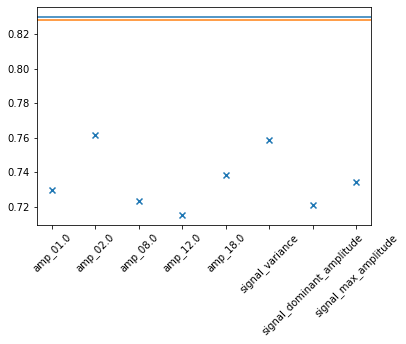

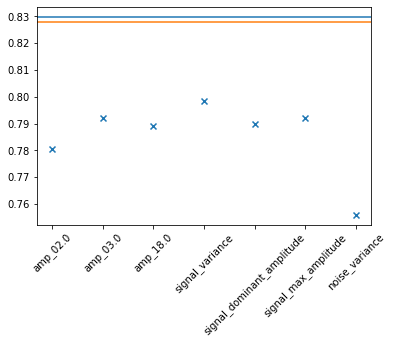

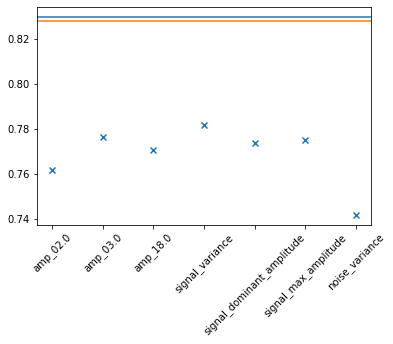

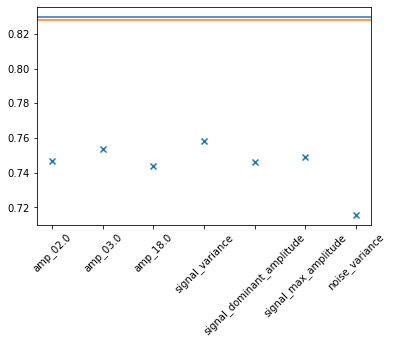

In [50]:
base_features = ['source_receiver_distance_logkm','source_depth_km', "receiver_back_azimuth", 'amp_ratio_01.0']

correlated_features = ["amp_01.0", 'amp_02.0', "amp_08.0", "amp_12.0", "amp_18.0", "signal_variance", 
                       "signal_dominant_amplitude", "signal_max_amplitude"]

cv_means = add_feat_to_base(base_features, correlated_features, all_features_cv=selected_feat_sr_cv, 
                           top_features_cv=top_feat_sr_cv)

base_features = ['source_receiver_distance_logkm','source_depth_km', "receiver_back_azimuth", 
                 'amp_ratio_01.0', "amp_01.0"]

correlated_features = ['amp_02.0',"amp_03.0", "amp_18.0", "signal_variance", 
                       "signal_dominant_amplitude", "signal_max_amplitude","noise_variance"]
cv_means_amp01  = add_feat_to_base(base_features, correlated_features, all_features_cv=selected_feat_sr_cv, 
                           top_features_cv=top_feat_sr_cv)

base_features = ['source_receiver_distance_logkm', "receiver_back_azimuth",'amp_ratio_01.0', "amp_01.0"]

correlated_features = ['amp_02.0',"amp_03.0", "amp_18.0", "signal_variance", 
                       "signal_dominant_amplitude", "signal_max_amplitude","noise_variance"]

cv_means_nodepth = add_feat_to_base(base_features, correlated_features, all_features_cv=selected_feat_sr_cv, 
                           top_features_cv=top_feat_sr_cv)

base_features = ['source_receiver_distance_logkm','amp_ratio_01.0', "amp_01.0"]

correlated_features = ['amp_02.0',"amp_03.0", "amp_18.0", "signal_variance", 
                       "signal_dominant_amplitude", "signal_max_amplitude","noise_variance"]

cv_means_nodepth_noba = add_feat_to_base(base_features, correlated_features, all_features_cv=selected_feat_sr_cv, 
                           top_features_cv=top_feat_sr_cv)

# SR distance is important 
# base_features = ["receiver_back_azimuth",'amp_ratio_01.0', "amp_01.0"]

# correlated_features = ['amp_02.0', "amp_08.0", "amp_12.0", "amp_18.0", "signal_variance", 
#                        "signal_dominant_amplitude", "signal_max_amplitude"]

# cv_means_nodepth_nosrd = add_feat_to_base(base_features, correlated_features, all_features_cv=selected_feat_sr_cv, 
#                            top_features_cv=top_feat_sr_cv)

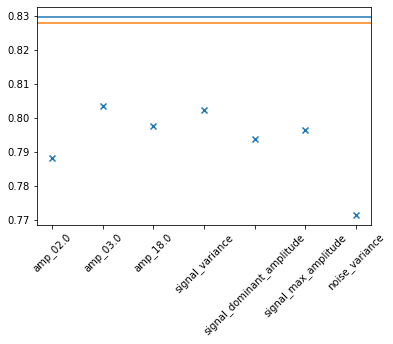

In [53]:
base_features = ['source_receiver_distance_logkm', "receiver_back_azimuth",'source_depth_km', 'amp_ratio_01.0', 
                 "amp_01.0", "amp_ratio_03.0"]

correlated_features = ['amp_02.0', "amp_03.0", "amp_18.0", "signal_variance", 
                       "signal_dominant_amplitude", "signal_max_amplitude", "noise_variance"]

cv_means_amp01_ampr03  = add_feat_to_base(base_features, correlated_features, all_features_cv=selected_feat_sr_cv, 
                           top_features_cv=top_feat_sr_cv)

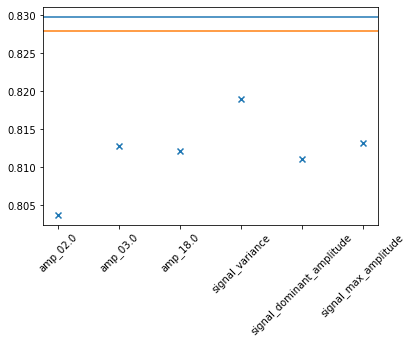

In [63]:
base_features = ['source_receiver_distance_logkm', "receiver_back_azimuth",'source_depth_km', 'amp_ratio_01.0', 
                 "amp_01.0", "noise_variance"]

correlated_features = ['amp_02.0', "amp_03.0", "amp_18.0", "signal_variance", 
                       "signal_dominant_amplitude", "signal_max_amplitude"]

cv_means_amp01_nv  = add_feat_to_base(base_features, correlated_features, all_features_cv=selected_feat_sr_cv, 
                           top_features_cv=top_feat_sr_cv)

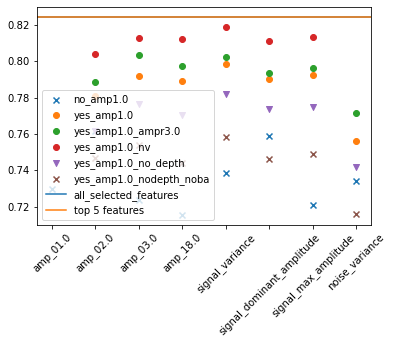

In [64]:
correlated_features = ["amp_01.0", 'amp_02.0',"amp_03.0", "amp_18.0", "signal_variance", 
                       "signal_dominant_amplitude", "signal_max_amplitude","noise_variance"]

plt.scatter( range(0,len(correlated_features)), cv_means, marker="x", label="no_amp1.0")
plt.scatter( range(1,len(correlated_features)), cv_means_amp01, marker="o", label="yes_amp1.0")
plt.scatter( range(1,len(correlated_features)), cv_means_amp01_ampr03, marker="o", label="yes_amp1.0_ampr3.0")
plt.scatter( range(1,len(correlated_features)-1), cv_means_amp01_nv, marker="o", label="yes_amp1.0_nv")
plt.scatter( range(1,len(correlated_features)), cv_means_nodepth, marker="v", label="yes_amp1.0_no_depth")
plt.scatter( range(1,len(correlated_features)), cv_means_nodepth_noba, marker="x", label="yes_amp1.0_nodepth_noba")
# plt.scatter( range(1,len(correlated_features)), cv_means_nodepth_nosrd, marker="x", label="yes_amp1.0_nodepth_nosr")

plt.xticks(range(len(correlated_features)), labels=correlated_features, rotation=45);
plt.axhline(np.mean(selected_feat_lat_lon_cv), label="all_selected_features")
plt.axhline(np.mean(top_feat_lat_lon_cv), color="C1", label="top 5 features")
plt.legend();

In [61]:
fewer_features_sr = ['source_receiver_distance_logkm', "receiver_back_azimuth",'amp_ratio_01.0', 
                          "amp_01.0", "signal_variance", "source_depth_km"]
fewer_feat_sr_df = train_feat_df.copy()[fewer_features_sr]
fewer_feat_sr_df.loc[:, "magnitude"] = train_y
corr = fewer_feat_sr_df.corr()
corr.style.background_gradient(cmap="coolwarm")

,source_receiver_distance_logkm,receiver_back_azimuth,amp_ratio_01.0,amp_01.0,signal_variance,source_depth_km,magnitude
source_receiver_distance_logkm,1.000000,-0.408669,-0.152621,-0.641105,-0.803982,-0.225107,0.029026
receiver_back_azimuth,-0.408669,1.000000,0.067509,0.351252,0.420874,0.359723,0.003117
amp_ratio_01.0,-0.152621,0.067509,1.000000,0.306092,0.258290,-0.031997,0.130479
amp_01.0,-0.641105,0.351252,0.306092,1.000000,0.884463,0.184531,0.553534
signal_variance,-0.803982,0.420874,0.258290,0.884463,1.000000,0.298744,0.363915
source_depth_km,-0.225107,0.359723,-0.031997,0.184531,0.298744,1.000000,0.024245
magnitude,0.029026,0.003117,0.130479,0.553534,0.363915,0.024245,1.000000


In [62]:
fewer_feat_sr_cv = svr_cv(train_feat_df_unscaled[fewer_features_sr], train_y, folds)
print(fewer_feat_sr_cv)
print(np.mean(fewer_feat_sr_cv))

[0.79558391 0.80162758 0.78082837 0.8061562  0.80798831]
0.7984368736496832
